In [ ]:
!pip install kaggle


In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedayman911","key":"0fbab47277901d937c4da98c2d72c6ef"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:07<00:00, 22.1MB/s]
100% 149M/149M [00:07<00:00, 20.1MB/s]


In [3]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob as gb
import cv2
import tensorflow  as tf
import keras
from tqdm import tqdm
from collections import Counter
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [5]:
#Data Path
height=150
width=150
color_channels=3
image_size = (width, height, color_channels)
num_classes = 4  # Adjust based on your specific dataset
train_path='/content/Training'
test_path='/content/Testing'
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
final_model_path = '/content/training_1'

In [6]:
def read_images_from_directory(folder_path, desc):
    """
    Analyzes the sizes of JPEG images within each subfolder of the given directory.

    Parameters:
    - train_path: str. The path to the directory containing subfolders of images.
    - desc: str. A description for the tqdm progress bar.

    Returns:
    - A pandas Series object with the counts of each unique image size.
    """
    images = []
    labels=[]

    # Iterate through each folder in the given directory with a progress bar

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + '/' + folder + '/*.jpg'))

        # For each file in the current folder, read the image and append its size
        for file in tqdm(files, desc=desc+" in "+folder):
            image = plt.imread(file)
            img_resized=cv2.resize(image,(width,height))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img_rgb)
            labels.append(folder)


    # Count the occurrence of each unique size
    return images,labels


In [7]:
x_train,y_train= read_images_from_directory(train_path, "Loading Training Data")

Loading Training Data in glioma: 100%|██████████| 1321/1321 [00:01<00:00, 981.70it/s] 


In [8]:
x_test,y_test= read_images_from_directory(test_path, "Loading Testing Data")

Loading Testing Data in glioma: 100%|██████████| 300/300 [00:00<00:00, 907.44it/s]


In [9]:
def visualize_data(list_of_images,labels):
  plt.figure(figsize=(20,20))
  for n,i in enumerate(list(np.random.randint(0,len(list_of_images),36))):
      plt.subplot(6,6,n+1)
      plt.imshow(list_of_images[i])
      plt.axis('off')
      plt.title(labels[i])


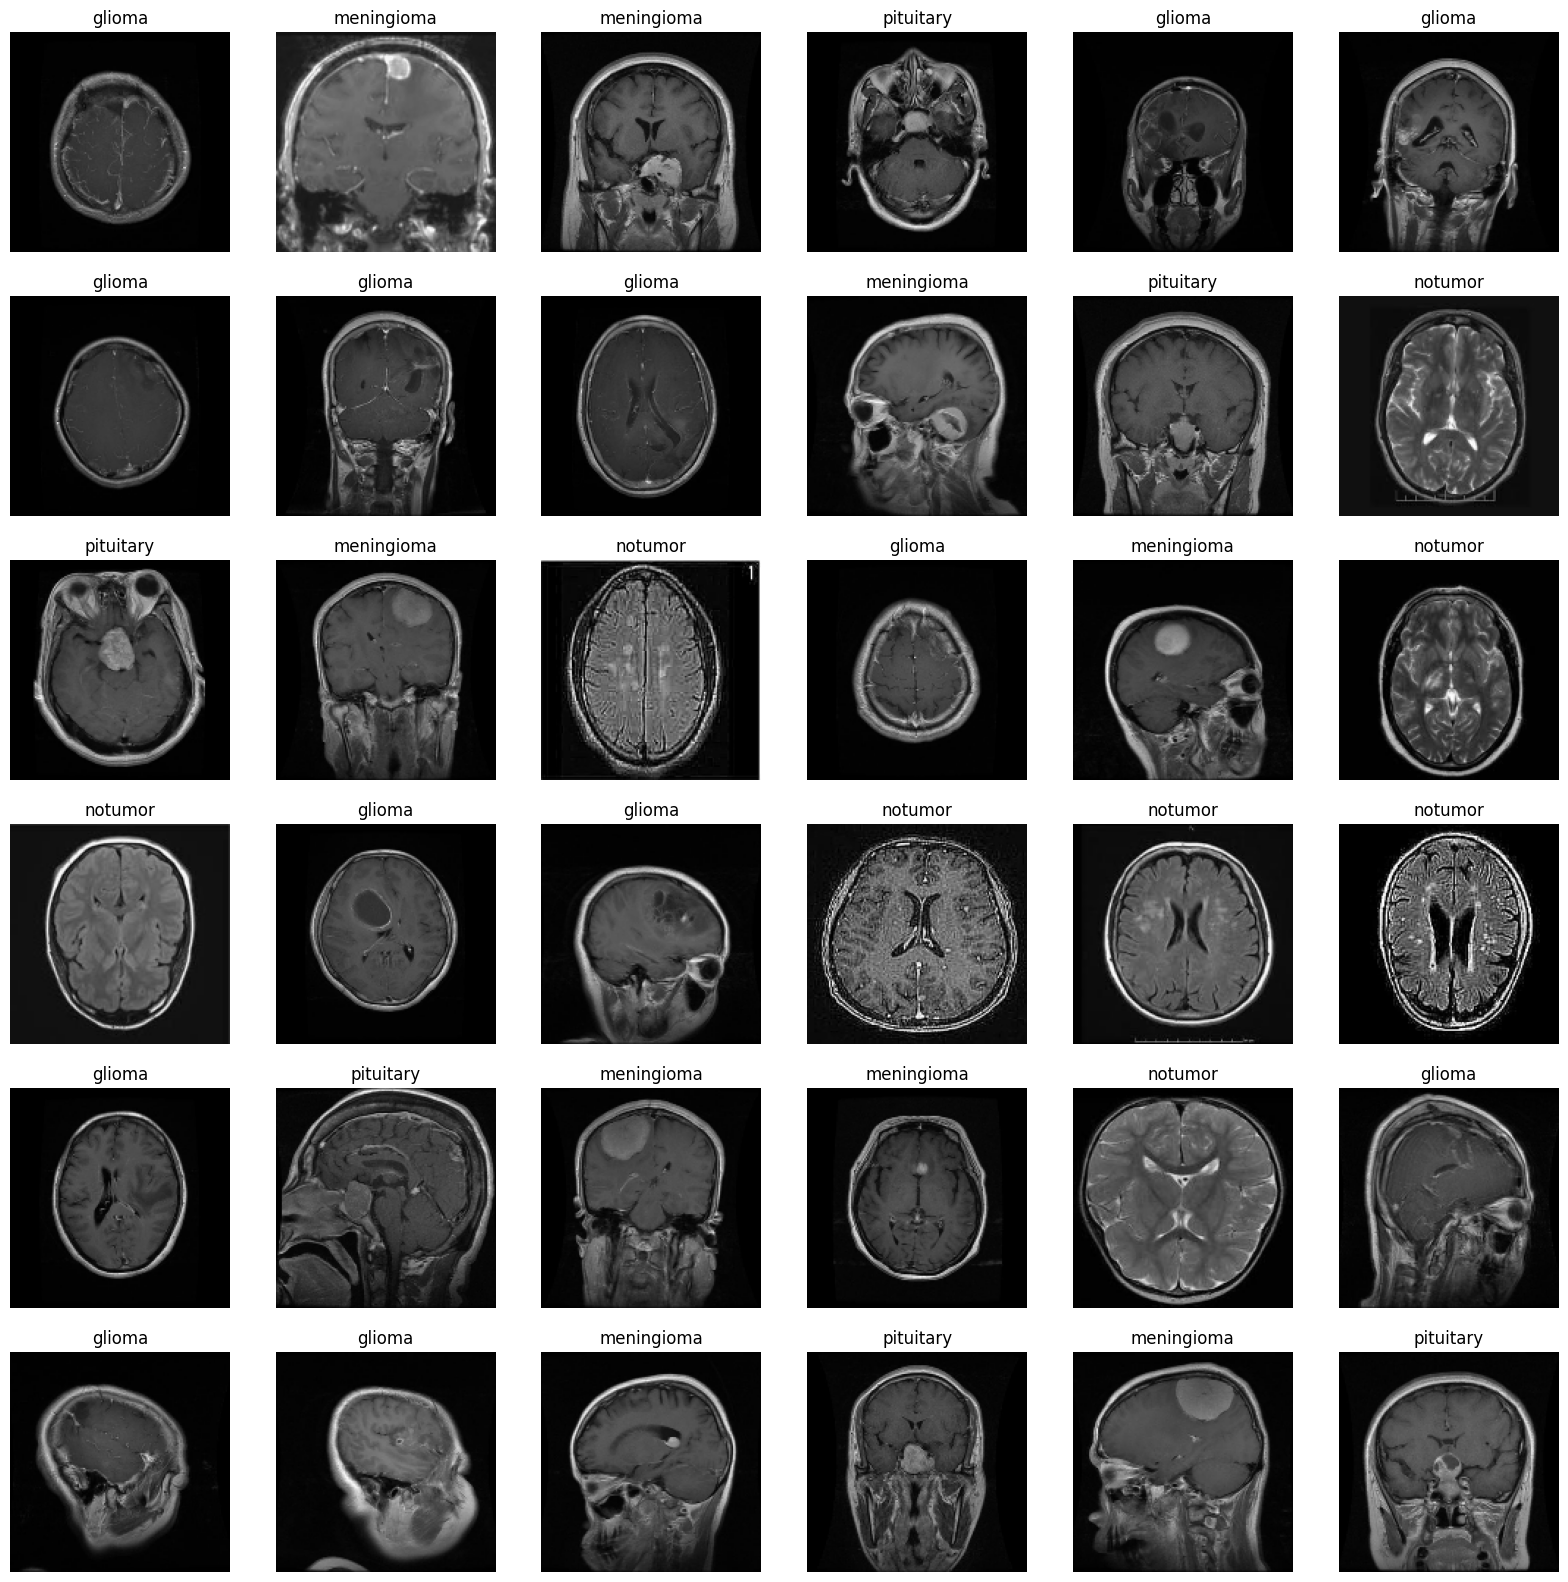

In [10]:
visualize_data(x_train,y_train)

In [11]:

def visualize_class_distribution(y_train, y_test):
    """
    Visualizes the class distribution in training and testing datasets when the labels are provided as lists.
    Adds a numeric label at the top of each bar showing the count.

    Parameters:
    - y_train: List of training labels.
    - y_test: List of testing labels.
    """
    train_counter = Counter(y_train)
    test_counter = Counter(y_test)

    all_labels = list(set(train_counter.keys()).union(set(test_counter.keys())))
    all_labels.sort()  # Sort the labels for consistent plotting
    train_counts = [train_counter[label] for label in all_labels]
    test_counts = [test_counter[label] for label in all_labels]

    x = range(len(all_labels))  # Label locations

    fig, ax = plt.subplots()
    train_bars = ax.bar([i - 0.2 for i in x], train_counts, width=0.4, label='Train', align='center')
    test_bars = ax.bar([i + 0.2 for i in x], test_counts, width=0.4, label='Test', align='center')

    ax.set_ylabel('Counts')
    ax.set_title('Class distribution in training and testing datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation='horizontal')
    ax.legend()

    def autolabel(bars):
        """Attach a text label above each bar displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(train_bars)
    autolabel(test_bars)

    plt.tight_layout()
    plt.show()


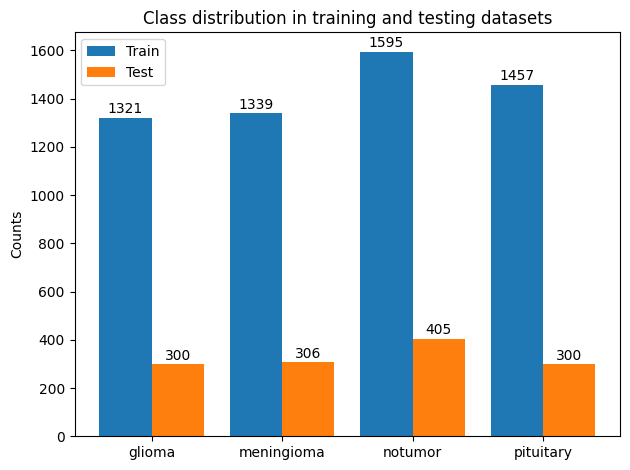

In [12]:
visualize_class_distribution(y_train, y_test)

In [13]:
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0


label_encoder = LabelEncoder()

# Fit the label encoder on the training labels and transform both training and test labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = np.array(y_train_encoded)
y_test = np.array(y_test_encoded)

print(f'X_train shape  is {x_train.shape}')
print(f'X_test shape  is {x_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (5712, 150, 150, 3)
X_test shape  is (1311, 150, 150, 3)
y_train shape  is (5712,)
y_test shape  is (1311,)


In [14]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and return encoded labels
y_train_encoded = np.array(label_encoder.fit_transform(y_train))
y_test_encoded = np.array(label_encoder.transform(y_test))

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = 0.2, # Randomly zoom image
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        # horizontal_flip = True,  # randomly flip images
        # vertical_flip=False # randomly flip images
        )


datagen.fit(x_train)


In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
def create_custom_cnn(image_size, num_classes):
    """
    Creates, compiles, prints a summary, and visualizes a custom CNN model with two convolutional layers and max pooling.

    Parameters:
    - image_size: tuple, the input size of the images (height, width, channels).
    - num_classes: int, the number of classes for the classification task.

    Returns:
    - The compiled model.
    """
    model = tf.keras.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_size, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    # Second convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers for classification
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    # Visualize the model
    visualization_path = 'model_visualization.png'
    tf.keras.utils.plot_model(model, to_file=visualization_path, show_shapes=True, show_layer_names=True)

    print(f"Model visualization saved to {visualization_path}")

    return model


In [27]:
single_model = create_custom_cnn(image_size, num_classes)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 dropout_2 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 69, 69, 64)        36928     
                                                      

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
batch_size = 32
epochs = 15
history = single_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(x_train) // batch_size,
                    validation_data = (x_test, y_test),
                    epochs=epochs,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/15
178/178 [==============================] - 42s 210ms/step - loss: 2.6262 - accuracy: 0.7021 - val_loss: 2.7992 - val_accuracy: 0.4569 - lr: 3.0000e-04
Epoch 2/15
178/178 [==============================] - 38s 213ms/step - loss: 1.7914 - accuracy: 0.8327 - val_loss: 2.0819 - val_accuracy: 0.6682 - lr: 3.0000e-04
Epoch 3/15
178/178 [==============================] - 38s 213ms/step - loss: 1.3951 - accuracy: 0.8831 - val_loss: 1.5416 - val_accuracy: 0.7925 - lr: 3.0000e-04
Epoch 4/15
178/178 [==============================] - 38s 212ms/step - loss: 1.2035 - accuracy: 0.8928 - val_loss: 1.2509 - val_accuracy: 0.8345 - lr: 3.0000e-04
Epoch 5/15
178/178 [==============================] - 37s 209ms/step - loss: 1.0490 - accuracy: 0.9106 - val_loss: 1.1365 - val_accuracy: 0.8520 - lr: 3.0000e-04
Epoch 6/15
178/178 [==============================] - 39s 218ms/step - loss: 0.9563 - accuracy: 0.9206 - val_loss: 1.0237 - val_accuracy: 0.8818 - lr: 3.0000e-04
Epoch 7/15
178/178 [========

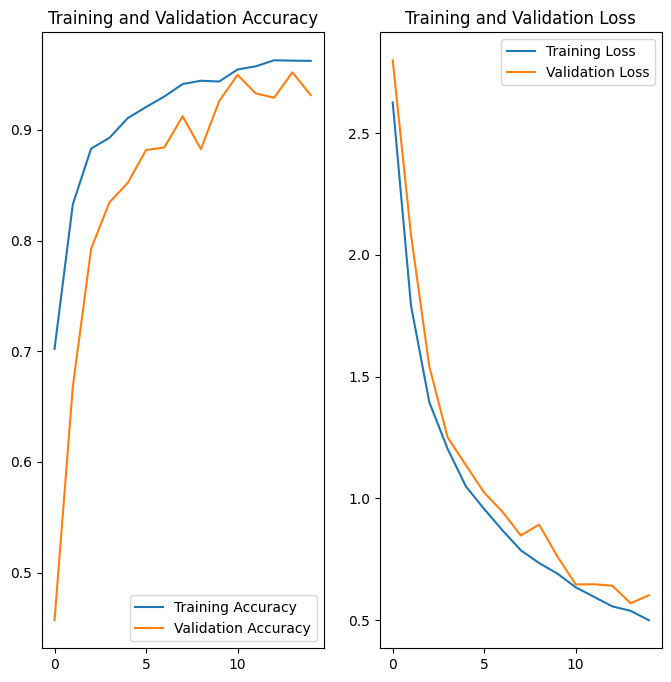

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming your validation data and labels are x_test and y_test respectively

# Predict the classes for the validation data
y_pred = np.argmax(single_model.predict(x_test), axis=-1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


41/41 [==============================] - 1s 16ms/step
Accuracy: 0.9314
Precision: 0.9317
Recall: 0.9314
F1 Score: 0.9312

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       300
           1       0.86      0.88      0.87       306
           2       0.96      0.96      0.96       405
           3       0.95      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311


Confusion Matrix:
[[264  34   0   2]
 [  8 270  16  12]
 [  6   8 390   1]
 [  2   1   0 297]]


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
single_model.save('/content/drive/MyDrive/From_Scratch')